## Merge two UTM zones

```
#
# Copyright (c) Sinergise, 2019 -- 2021.
#
# This file belongs to subproject "field-delineation" of project NIVA (www.niva4cap.eu).
# All rights reserved.
#
# This source code is licensed under the MIT license found in the LICENSE
# file in the root directory of this source tree.
#
```

This notebook implements the methods needed to merge two UTM zones into a single output geopackage.

The procedure outline is:
* define geometries for two UTM zones and their overlap
* load the two single-UTM-zone vector predictions
* split them into parts: non-overlapping (completely within UTM zone) and overlapping
* merge the overlaps by:
  * transform them to single CRS (WGS84)
  * spatial join of the overlapping geodataframes from the two zones
  * finding geometries that do not overlap (and keeping them)
  * unary_union-ize the polygons that intersect and merge them to the geometries from previous step
* transform everything to resulting (common) CRS
* clean up the results (remove geometries with area larger than X * largest GSAA polygon from 2020
* simplify geometries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union

from fd.vectorisation import MergeUTMsConfig, utm_zone_merging

### The two UTM zones and their overlap

In [3]:
INPUT_DATA_DIR = Path('../../input-data/')

grid_definition = gpd.read_file(INPUT_DATA_DIR/'cyl-grid-definition.gpkg')
grid_definition.head()

,id,name,geometry
0,2302137,30TVM_2_5,"POLYGON ((-3.96458 41.90790, -3.96594 41.99795..."
1,2301391,30TUN_7_8,"POLYGON ((-4.58294 42.53146, -4.58522 42.62148..."
2,2301392,30TUN_7_9,"POLYGON ((-4.58067 42.44143, -4.58294 42.53146..."
3,2301398,30TUN_8_5,"POLYGON ((-4.46755 42.80315, -4.46969 42.89318..."
4,2301399,30TUN_8_6,"POLYGON ((-4.46543 42.71313, -4.46755 42.80315..."


In [4]:
grid_definition['crs'] = grid_definition['name'].apply(lambda name: f'326{name[:2]}')
grid_definition.head()

,id,name,geometry,crs
0,2302137,30TVM_2_5,"POLYGON ((-3.96458 41.90790, -3.96594 41.99795...",32630
1,2301391,30TUN_7_8,"POLYGON ((-4.58294 42.53146, -4.58522 42.62148...",32630
2,2301392,30TUN_7_9,"POLYGON ((-4.58067 42.44143, -4.58294 42.53146...",32630
3,2301398,30TUN_8_5,"POLYGON ((-4.46755 42.80315, -4.46969 42.89318...",32630
4,2301399,30TUN_8_6,"POLYGON ((-4.46543 42.71313, -4.46755 42.80315...",32630


In [5]:
crs_names = sorted(grid_definition['crs'].unique())
crs_names

['32629', '32630']

In [6]:
utm_geoms = [grid_definition[grid_definition['crs']==crs_name].geometry.unary_union 
             for crs_name in crs_names]

In [7]:
overlap = utm_geoms[0].intersection(utm_geoms[1]).buffer(-0.0001)

In [8]:
tiled_overlap = grid_definition[grid_definition.intersects(overlap)].unary_union.buffer(-0.0001)

In [9]:
zones = gpd.GeoDataFrame(geometry=[g for g in grid_definition[~grid_definition.intersects(tiled_overlap)].buffer(0.00001).unary_union],
                         crs=grid_definition.crs)
zones['crs'] = zones.geometry.apply(lambda g: grid_definition[grid_definition.intersects(g)]['crs'].unique()[0])

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [10]:
# a dataframe holding the overlap geometry
# useful because it is much simpler to transform between CRSs 

overlap_df = gpd.GeoDataFrame(geometry=[tiled_overlap], crs=grid_definition.crs)

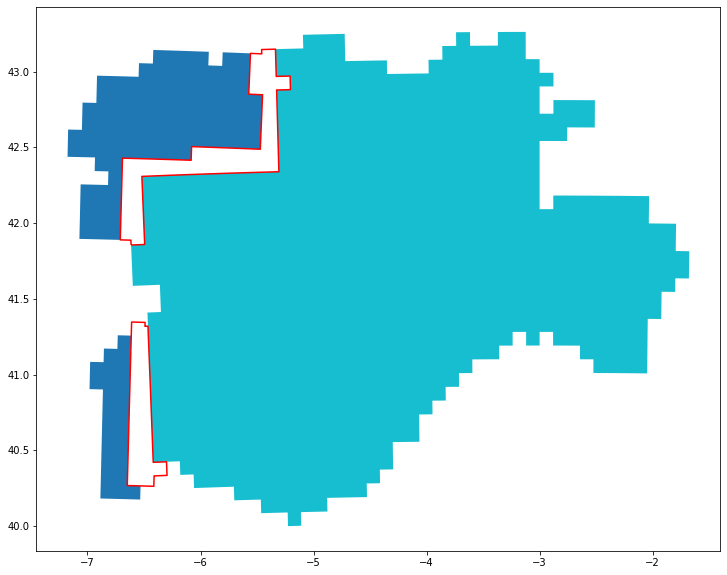

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
zones.plot('crs', ax=ax)
overlap_df.boundary.plot(ax=ax, color='r')

In [12]:
MAX_GSAA_AREA = 19824325 # m2, derived from reference data

merging_config = MergeUTMsConfig(
    bucket_name='bucket-name',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    time_intervals=['APRIL'],
    utms=crs_names,
    contours_dir='/home/ubuntu/cyl-contours', # where partial vectors are stored
    resulting_crs='epsg:2062', # CRS of resulting geometries
    max_area=1.3*MAX_GSAA_AREA, # Specify max area in m2 of parcels to keep
    simplify_tolerance=2.5, # This is in teh resulting CRS, careful about unit of measure
    n_workers=20
)

In [13]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

Depending on the number of polygons in the overlap area, and on their size, this step can take quite a long time (appr 4 hours per time interval).

In [14]:
utm_zone_merging(merging_config, overlap_df, zones, parallel=False)

2021-01-10 08:20:51,743 | INFO : merging utms for APRIL ...
2021-01-10 08:23:24,857 | INFO : 	filter vectors by area ...
2021-01-10 08:23:26,301 | INFO : Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-01-10 08:23:26,302 | INFO : NumExpr defaulting to 8 threads.
2021-01-10 08:23:36,612 | INFO : 	splitting away non-overlapping zones ...
2021-01-10 08:34:01,363 | INFO : 	finding overlapping geometries with sjoin ...
2021-01-10 08:35:45,188 | INFO : 	running union of 33532 overlapping geometries ...


/home/ubuntu/field-delineation/fd/vectorisation.py:487: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = overlaps[overlaps.geometry.area>0]


2021-01-10 08:37:38,955 | INFO : 	create dataframe of overlaps ...
2021-01-10 13:34:26,978 | INFO : 	merging results ...
2021-01-10 13:46:18,558 | INFO : 	simplifying geometries ...
2021-01-10 14:44:38,843 | INFO : 	writing output ...
